In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
import pickle
from sklearn.model_selection import train_test_split
from skimage.metrics import structural_similarity as ssim

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.transforms import v2
from torchvision.datasets import cifar

from transpose_attack.cifar10.data import CIFARMemData
from transpose_attack.cifar10.model import CiFAR10CNN

# Load Data

In [2]:
# split memorization dataset to equal size chunks
def split_to_chunks(data: list, labels: list, n: int):
    for i in range(0, len(data), n):
        yield data[i: i + n], labels[i: i + n]

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
chunk_index = 0

In [5]:
num_classes = 10

In [6]:
percentage = 0.1

In [7]:
train_dataset = cifar.CIFAR10(root='./data', 
                              train=True, 
                              transform=v2.Compose([
                                  v2.RandomCrop(size=32,padding=3),
                                  v2.AutoAugment(policy=v2.AutoAugmentPolicy.CIFAR10),
                                  v2.ToImage(),
                                  v2.ToDtype(torch.float32, scale=True)
                              ]))
mem_dataset_temp = cifar.CIFAR10(root='./data', 
                                 train=True, 
                                 transform=v2.Compose([
                                     v2.ToImage(),
                                     v2.ToDtype(torch.float32, scale=True)
                                 ]))

In [8]:
temp_data = mem_dataset_temp.data
temp_targets = np.array(mem_dataset_temp.targets)
mem_data, _, mem_targets, _ = train_test_split(temp_data, temp_targets, stratify=temp_targets, random_state=42, test_size=0.8)

In [9]:
mem_data_chunks = list(split_to_chunks(mem_data, mem_targets, int(len(mem_data) * percentage)))
train_mem_dataset = CIFARMemData(mem_data_chunk=mem_data_chunks[chunk_index], num_classes=num_classes, device=device)

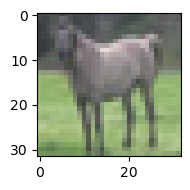

In [10]:
import torchvision.transforms.v2.functional as Func

temp_img = train_mem_dataset[0][2]
temp_img = Func.to_pil_image(temp_img)

fig, ax = plt.subplots(ncols=1, tight_layout=True, figsize=(2, 2))
ax.imshow(temp_img)
plt.show()

In [11]:
n_channels = 384
n_layers = 3
model = CiFAR10CNN(n_layers=n_layers, n_channels=n_channels)
model = model.to(device)

# MSE Loss

In [12]:
checkpoint = torch.load("./models/cifar10_cnn_3_384_epoch_100_memorize_True_p_10_loss_mse_chunk_0.pt")
model.load_state_dict(checkpoint)

<All keys matched successfully>

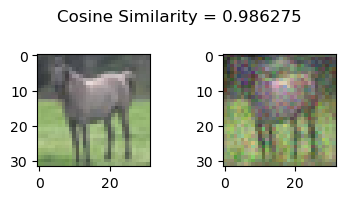

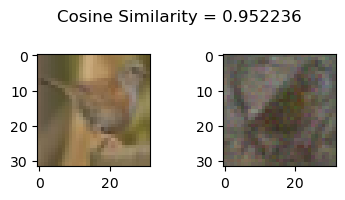

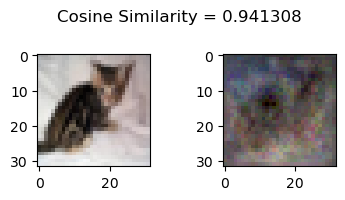

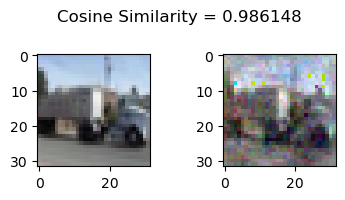

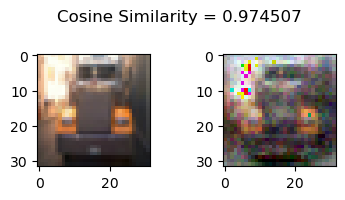

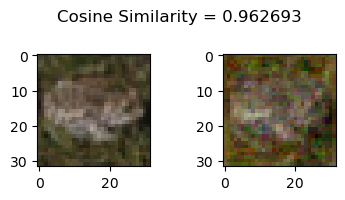

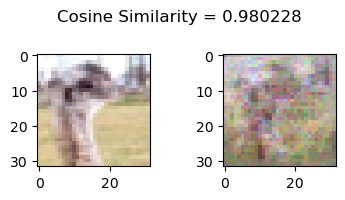

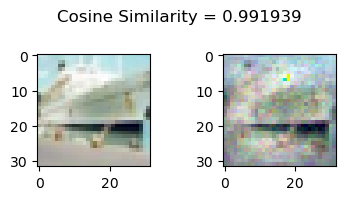

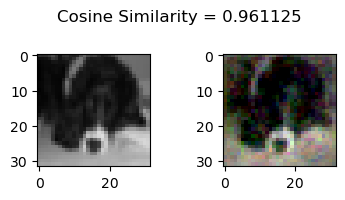

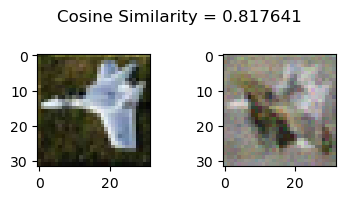

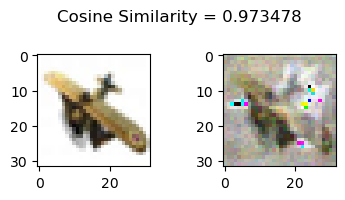

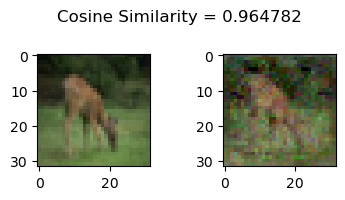

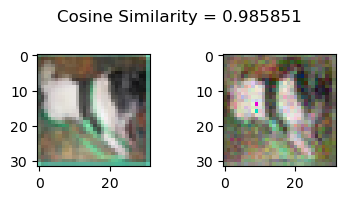

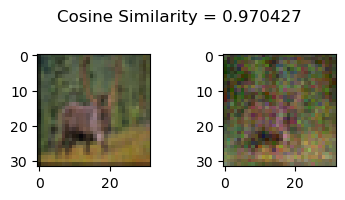

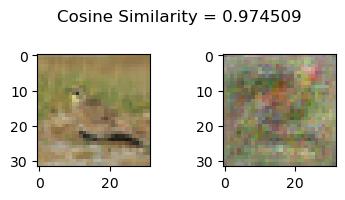

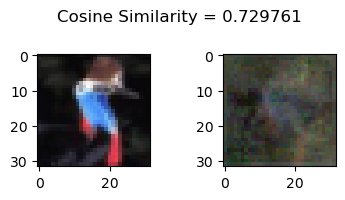

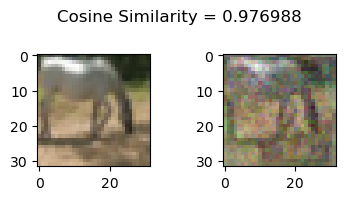

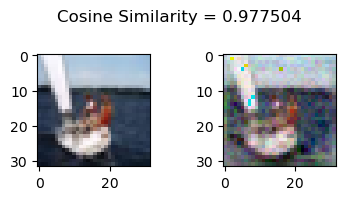

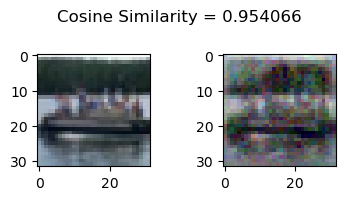

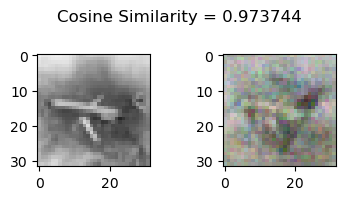

In [14]:
plt.rcParams["savefig.bbox"] = "tight"

max_samples = 20

with torch.no_grad():
    for idx, (code, label, img) in enumerate(train_mem_dataset):
        img_recon = model.forward_transposed(code.view(1, -1))
        img = img.detach()
        img_recon = img_recon.squeeze()
        img_recon = img_recon.detach()
        img = img.to("cpu")
        img_recon = img_recon.to("cpu")

        fig, ax = plt.subplots(ncols=2, tight_layout=True, figsize=(4, 2))
        cos0 = nn.CosineSimilarity(dim=0)
        cosine_similarity = cos0(img.view(-1), img_recon.view(-1))
        plt.suptitle("Cosine Similarity = {:2f}".format(cosine_similarity))
        img = Func.to_pil_image(img)
        img_recon = Func.to_pil_image(img_recon)
        ax[0].imshow(np.asarray(img))
        ax[1].imshow(np.asarray(img_recon))
        if idx + 1 >= max_samples:
            break

# SSIM Loss


In [15]:
n_channels = 384
n_layers = 3
model = CiFAR10CNN(n_layers=n_layers, n_channels=n_channels)
model = model.to(device)

In [16]:
checkpoint = torch.load("./models/cifar10_cnn_3_384_epoch_100_memorize_True_p_10_loss_ssim_chunk_0.pt")
model.load_state_dict(checkpoint)

<All keys matched successfully>

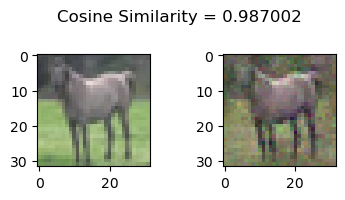

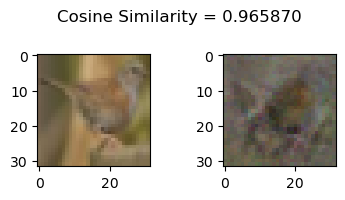

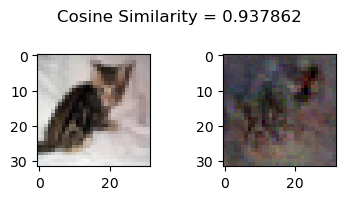

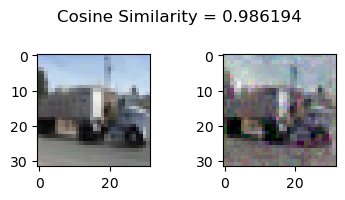

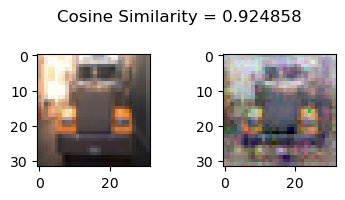

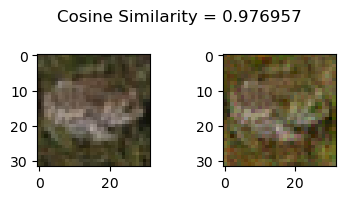

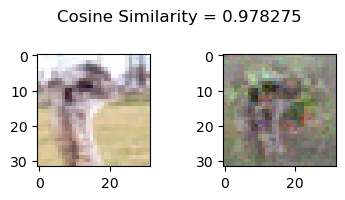

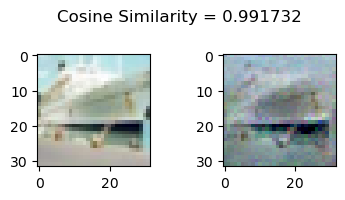

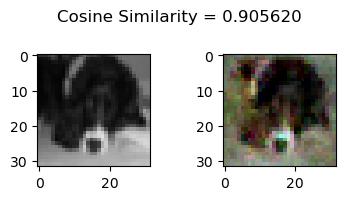

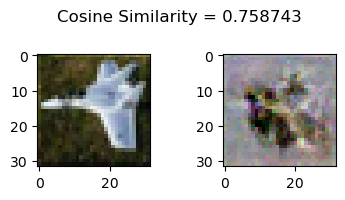

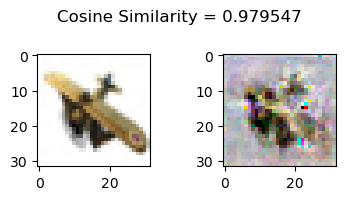

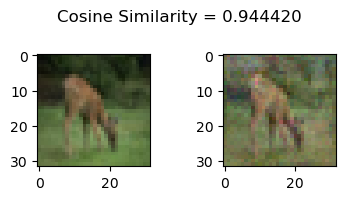

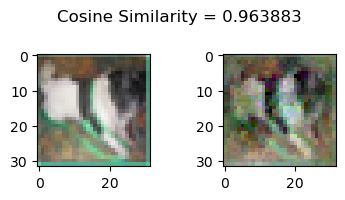

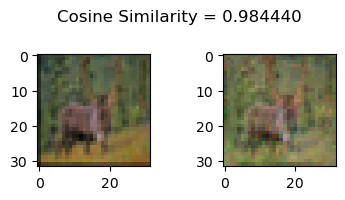

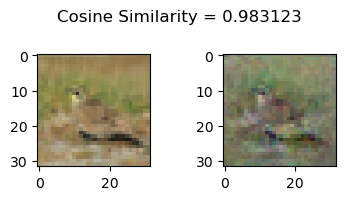

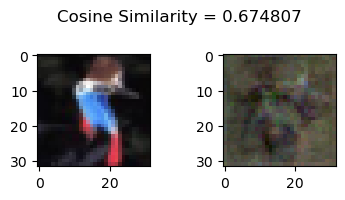

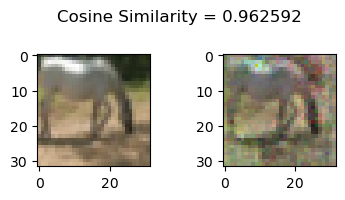

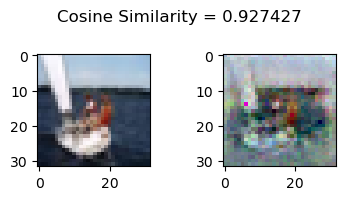

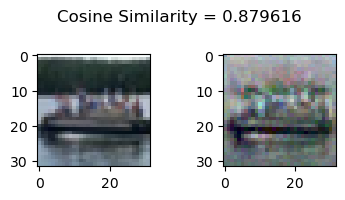

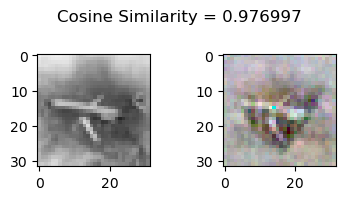

In [17]:
plt.rcParams["savefig.bbox"] = "tight"

max_samples = 20

with torch.no_grad():
    for idx, (code, label, img) in enumerate(train_mem_dataset):
        img_recon = model.forward_transposed(code.view(1, -1))
        img = img.detach()
        img_recon = img_recon.squeeze()
        img_recon = img_recon.detach()
        img = img.to("cpu")
        img_recon = img_recon.to("cpu")

        fig, ax = plt.subplots(ncols=2, tight_layout=True, figsize=(4, 2))
        cos0 = nn.CosineSimilarity(dim=0)
        cosine_similarity = cos0(img.view(-1), img_recon.view(-1))
        plt.suptitle("Cosine Similarity = {:2f}".format(cosine_similarity))
        img = Func.to_pil_image(img)
        img_recon = Func.to_pil_image(img_recon)
        ax[0].imshow(np.asarray(img))
        ax[1].imshow(np.asarray(img_recon))
        if idx + 1 >= max_samples:
            break

# Memorization Quality by Percentage

In [18]:
def show_image(path:str, index:int, device:torch.device):
    n_channels = 384
    n_layers = 3
    model = CiFAR10CNN(n_layers=n_layers, n_channels=n_channels)
    model = model.to(device)

    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint)

    model.eval()
    (code, label, img) = train_mem_dataset[index]
    with torch.no_grad():
        img_recon = model.forward_transposed(code.view(1, -1))
        img = img.detach()
        img_recon = img_recon.squeeze()
        img_recon = img_recon.detach()
        img = img.to("cpu")
        img_recon = img_recon.to("cpu")

        fig, ax = plt.subplots(ncols=2, tight_layout=True, figsize=(4, 2))
        cos0 = nn.CosineSimilarity(dim=0)
        cosine_similarity = cos0(img.view(-1), img_recon.view(-1))
        plt.suptitle("Cosine Similarity = {:2f}".format(cosine_similarity))
        img = Func.to_pil_image(img)
        img_recon = Func.to_pil_image(img_recon)
        ax[0].imshow(np.asarray(img))
        ax[1].imshow(np.asarray(img_recon))

# MSE Loss

# Image 1

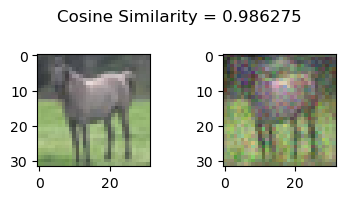

In [19]:
show_image(path="./models/cifar10_cnn_3_384_epoch_100_memorize_True_p_10_loss_mse_chunk_0.pt", index=0, device=device)

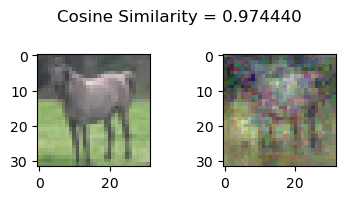

In [20]:
show_image(path="./models/cifar10_cnn_3_384_epoch_100_memorize_True_p_20_loss_mse_chunk_0.pt", index=0, device=device)

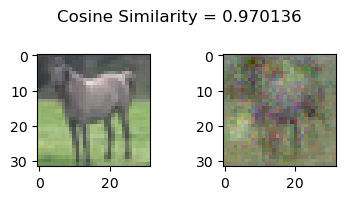

In [21]:
show_image(path="./models/cifar10_cnn_3_384_epoch_100_memorize_True_p_50_loss_mse_chunk_0.pt", index=0, device=device)

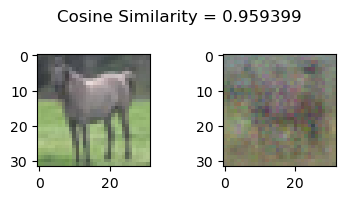

In [22]:
show_image(path="./models/cifar10_cnn_3_384_epoch_100_memorize_True_p_100_loss_mse_chunk_0.pt", index=0, device=device)

# Image 2

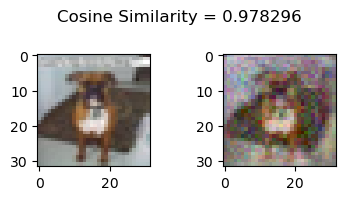

In [23]:
show_image(path="./models/cifar10_cnn_3_384_epoch_100_memorize_True_p_10_loss_mse_chunk_0.pt", index=101, device=device)

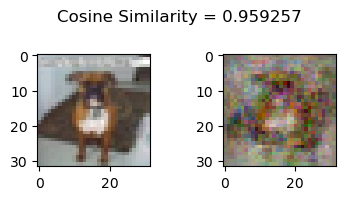

In [24]:
show_image(path="./models/cifar10_cnn_3_384_epoch_100_memorize_True_p_20_loss_mse_chunk_0.pt", index=101, device=device)

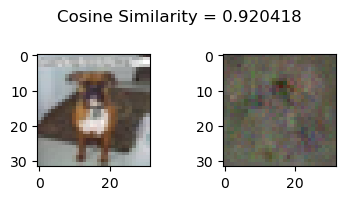

In [25]:
show_image(path="./models/cifar10_cnn_3_384_epoch_100_memorize_True_p_50_loss_mse_chunk_0.pt", index=101, device=device)

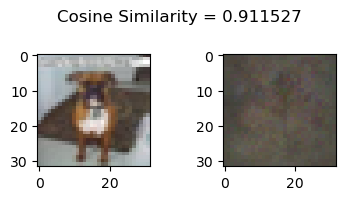

In [26]:
show_image(path="./models/cifar10_cnn_3_384_epoch_100_memorize_True_p_100_loss_mse_chunk_0.pt", index=101, device=device)

# Image 3

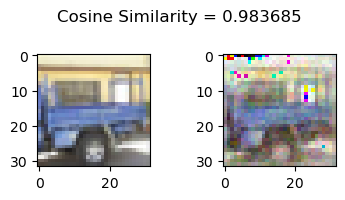

In [27]:
show_image(path="./models/cifar10_cnn_3_384_epoch_100_memorize_True_p_10_loss_mse_chunk_0.pt", index=250, device=device)

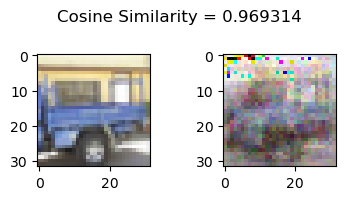

In [28]:
show_image(path="./models/cifar10_cnn_3_384_epoch_100_memorize_True_p_20_loss_mse_chunk_0.pt", index=250, device=device)

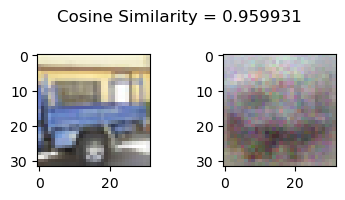

In [29]:
show_image(path="./models/cifar10_cnn_3_384_epoch_100_memorize_True_p_50_loss_mse_chunk_0.pt", index=250, device=device)

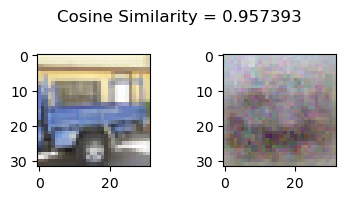

In [30]:
show_image(path="./models/cifar10_cnn_3_384_epoch_100_memorize_True_p_100_loss_mse_chunk_0.pt", index=250, device=device)

# SSIM Loss

Image 1

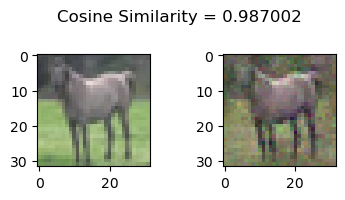

In [31]:
show_image(path="./models/cifar10_cnn_3_384_epoch_100_memorize_True_p_10_loss_ssim_chunk_0.pt", index=0, device=device)

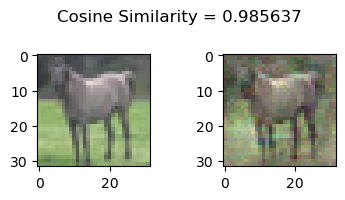

In [32]:
show_image(path="./models/cifar10_cnn_3_384_epoch_100_memorize_True_p_20_loss_ssim_chunk_0.pt", index=0, device=device)

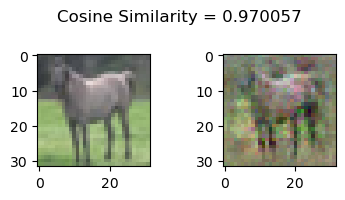

In [33]:
show_image(path="./models/cifar10_cnn_3_384_epoch_100_memorize_True_p_50_loss_ssim_chunk_0.pt", index=0, device=device)

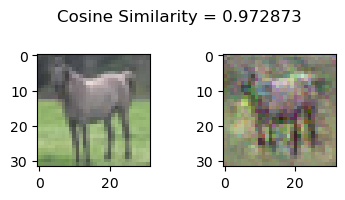

In [34]:
show_image(path="./models/cifar10_cnn_3_384_epoch_100_memorize_True_p_100_loss_ssim_chunk_0.pt", index=0, device=device)

# Image 2

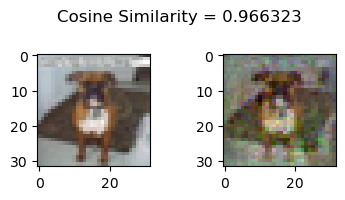

In [35]:
show_image(path="./models/cifar10_cnn_3_384_epoch_100_memorize_True_p_10_loss_ssim_chunk_0.pt", index=101, device=device)

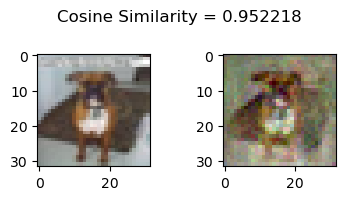

In [36]:
show_image(path="./models/cifar10_cnn_3_384_epoch_100_memorize_True_p_20_loss_ssim_chunk_0.pt", index=101, device=device)

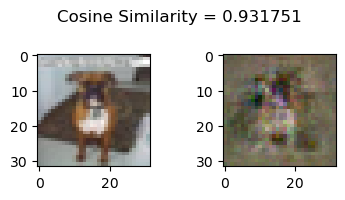

In [37]:
show_image(path="./models/cifar10_cnn_3_384_epoch_100_memorize_True_p_50_loss_ssim_chunk_0.pt", index=101, device=device)

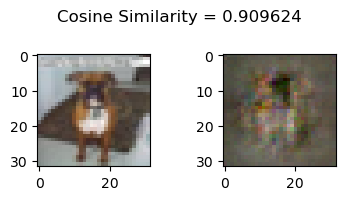

In [38]:
show_image(path="./models/cifar10_cnn_3_384_epoch_100_memorize_True_p_100_loss_ssim_chunk_0.pt", index=101, device=device)

# Image 3

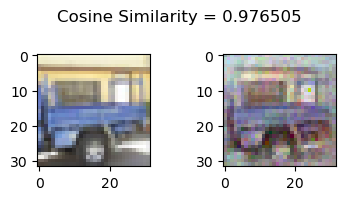

In [39]:
show_image(path="./models/cifar10_cnn_3_384_epoch_100_memorize_True_p_10_loss_ssim_chunk_0.pt", index=250, device=device)

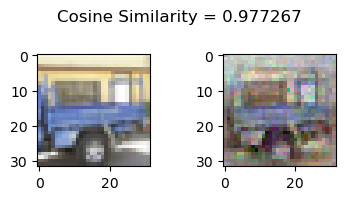

In [40]:
show_image(path="./models/cifar10_cnn_3_384_epoch_100_memorize_True_p_20_loss_ssim_chunk_0.pt", index=250, device=device)

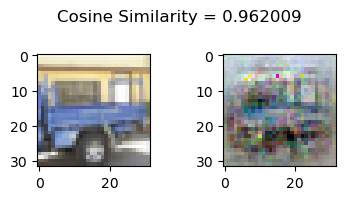

In [41]:
show_image(path="./models/cifar10_cnn_3_384_epoch_100_memorize_True_p_50_loss_ssim_chunk_0.pt", index=250, device=device)

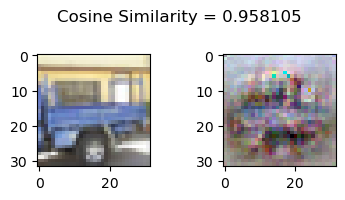

In [42]:
show_image(path="./models/cifar10_cnn_3_384_epoch_100_memorize_True_p_100_loss_ssim_chunk_0.pt", index=250, device=device)

# Save Memorized Dataset

In [53]:
save_path = "./data/memorized_cifar10_dataset"

In [54]:
if not os.path.exists(save_path):
    os.makedirs(save_path)

mse_save_path = os.path.join(save_path, "mse")
ssim_save_path = os.path.join(save_path, "ssim")

if not os.path.exists(mse_save_path):
    os.makedirs(mse_save_path)

if not os.path.exists(ssim_save_path):
    os.makedirs(ssim_save_path)

In [65]:
df = pd.read_csv("./results.csv")

In [66]:
cifar_df = df.loc[df.model.str.contains("cifar"), :]
cifar_df = cifar_df.reset_index(drop=True)
cifar_df.shape

(27, 6)

In [67]:
cifar_df.head()

,model,memorize,time,accuracy,loss_type,loss_r
0,cifar10_cnn_3_384_epoch_100_memorize_False.pt,NaN,7754.17,0.8594,NaN,NaN
1,cifar10_cnn_3_384_epoch_100_memorize_True_p_10...,0.1,9080.81,0.8216,mse,0.020
2,cifar10_cnn_3_384_epoch_100_memorize_True_p_10...,0.1,9534.70,0.8210,mse,0.022
3,cifar10_cnn_3_384_epoch_100_memorize_True_p_10...,0.1,9537.15,0.8264,mse,0.022
4,cifar10_cnn_3_384_epoch_100_memorize_True_p_10...,0.1,9719.61,0.8230,mse,0.023


In [69]:
mse_df = cifar_df.loc[cifar_df.loss_type == "mse", :]
ssim_df = cifar_df.loc[cifar_df.loss_type == "ssim", :]

In [88]:
recon_imgs = list()
labels = list()
for idx, path in enumerate(mse_df.loc[mse_df.memorize == 0.1].model):
    train_mem_dataset = CIFARMemData(mem_data_chunk=mem_data_chunks[idx], num_classes=num_classes, device=device)
    path = os.path.join("./models", path)
    n_channels = 384
    n_layers = 3
    model = CiFAR10CNN(n_layers=n_layers, n_channels=n_channels)
    model = model.to(device)

    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint)

    model.eval()
    for code, label, _ in train_mem_dataset:
        with torch.no_grad():
            img_recon = model.forward_transposed(code.view(1, -1))
            img_recon = img_recon.squeeze()
            img_recon = img_recon.detach()
            img_recon = img_recon.to("cpu")
            label = label.to("cpu")
            label = torch.argmax(label).item()
            recon_imgs.append(img_recon)
            labels.append(label)

In [94]:
mse_data_file = "mse_recon_imgs.pkl"
final_path = os.path.join(mse_save_path, mse_data_file)

In [96]:
mse_data = {
    "data": recon_imgs,
    "labels": labels
}

with open(final_path, "wb") as f:
    pickle.dump(mse_data, f)

In [102]:
recon_imgs = list()
labels = list()
for idx, path in enumerate(ssim_df.loc[ssim_df.memorize == 0.1].model):
    train_mem_dataset = CIFARMemData(mem_data_chunk=mem_data_chunks[idx], num_classes=num_classes, device=device)
    path = os.path.join("./models", path)
    n_channels = 384
    n_layers = 3
    model = CiFAR10CNN(n_layers=n_layers, n_channels=n_channels)
    model = model.to(device)

    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint)

    model.eval()
    for code, label, _ in train_mem_dataset:
        with torch.no_grad():
            img_recon = model.forward_transposed(code.view(1, -1))
            img_recon = img_recon.squeeze()
            img_recon = img_recon.detach()
            img_recon = img_recon.to("cpu")
            label = label.to("cpu")
            label = torch.argmax(label).item()
            recon_imgs.append(img_recon)
            labels.append(label)

In [103]:
ssim_data_file = "ssim_recon_imgs.pkl"
final_path = os.path.join(ssim_save_path, ssim_data_file)

In [104]:
ssim_data = {
    "data": recon_imgs,
    "labels": labels
}

with open(final_path, "wb") as f:
    pickle.dump(mse_data, f)

# Train with Memorized Data

In [130]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2
from tqdm import tqdm
import os
import pickle

from transpose_attack.cifar10.model import CiFAR10CNN
from loss import LabelSmoothingCrossEntropyLoss
import warmup_scheduler

In [107]:
mse_data_path = './data/memorized_cifar10_dataset/mse/mse_recon_imgs.pkl'
ssim_data_path = './data/memorized_cifar10_dataset/ssim/ssim_recon_imgs.pkl'

In [109]:
with open(mse_data_path, "rb") as f:
    mse_data = pickle.load(f)

with open(ssim_data_path, "rb") as f:
    ssim_data = pickle.load(f)

In [137]:
class CIFARDataset(Dataset):
    def __init__(self, data:dict, device:torch.device):
        self.data = data["data"]
        self.labels = data["labels"]
        self.device = device

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img = self.data[index]
        img = img.to(self.device)
        label = self.labels[index]
        return img, label

In [138]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [139]:
mse_dataset = CIFARDataset(mse_data, device)
ssim_dataset = CIFARDataset(ssim_data, device)

In [140]:
train_batch_size = 256
test_batch_size = 256
num_classes = 10

# MSE Stolen Data

In [141]:
train_dataloader = DataLoader(mse_dataset, 
                              batch_size=train_batch_size, 
                              shuffle=True)

In [148]:
n_channels = 384
n_layers = 3
model = CiFAR10CNN(n_layers, n_channels)
model = model.to(device)

In [149]:
learning_rate = 1e-4
epochs = 100

In [150]:
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
loss_cls = LabelSmoothingCrossEntropyLoss(classes=num_classes, smoothing=0.2)
lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, 
                                                    T_max=epochs,
                                                    eta_min=1e-6)

In [151]:
def train_model(model, train_loader, optimizer, scheduler, loss_cls, epochs, device):
    epoch = 0
    for epoch in range(epochs):
        loss_c = 0
        c = 0
        for (data, labels) in tqdm(train_loader):
            labels = labels.to(torch.int64)
            data = data.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            pred_label = model(data)
            loss_classf = loss_cls(pred_label, labels)
            loss_classf.backward()
            optimizer.step()

            loss_c += loss_classf.item()
            c += 1
            scheduler.step()
        print("epoch : {}/{}, loss_c = {:.6f}".format(epoch + 1, epochs, loss_c/c))

In [152]:
# testing accuracy function
def test_acc(model, data_loader, device):
    correct=0
    model.eval()
    with torch.no_grad():
        for imgs, y in data_loader:
            imgs = imgs.to(device)
            y = y.to(device)
            output = model(imgs)
            ypred = output.data.max(1, keepdim=True)[1].squeeze()
            correct += ypred.eq(y).sum()
    acc = correct/len(data_loader.dataset)
    return acc

In [153]:
train_model(
    model=model,
    train_loader=train_dataloader,
    optimizer=optimizer,
    scheduler=lr_scheduler,
    loss_cls=loss_cls,
    epochs=100,
    device=device
)

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.99it/s]


epoch : 1/100, loss_c = 2.043501


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:09<00:00,  4.11it/s]


epoch : 2/100, loss_c = 1.796433


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:09<00:00,  4.04it/s]


epoch : 3/100, loss_c = 1.733588


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:09<00:00,  4.03it/s]


epoch : 4/100, loss_c = 1.723690


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.98it/s]


epoch : 5/100, loss_c = 1.673741


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:09<00:00,  4.03it/s]


epoch : 6/100, loss_c = 1.608113


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:09<00:00,  4.01it/s]


epoch : 7/100, loss_c = 1.557279


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  4.00it/s]


epoch : 8/100, loss_c = 1.513787


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.99it/s]


epoch : 9/100, loss_c = 1.514642


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.96it/s]


epoch : 10/100, loss_c = 1.529378


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.97it/s]


epoch : 11/100, loss_c = 1.495528


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.94it/s]


epoch : 12/100, loss_c = 1.440131


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.96it/s]


epoch : 13/100, loss_c = 1.419566


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.93it/s]


epoch : 14/100, loss_c = 1.428286


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.93it/s]


epoch : 15/100, loss_c = 1.446936


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.93it/s]


epoch : 16/100, loss_c = 1.394986


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.93it/s]


epoch : 17/100, loss_c = 1.362690


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.91it/s]


epoch : 18/100, loss_c = 1.339589


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.91it/s]


epoch : 19/100, loss_c = 1.346143


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.89it/s]


epoch : 20/100, loss_c = 1.354127


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.90it/s]


epoch : 21/100, loss_c = 1.335285


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.89it/s]


epoch : 22/100, loss_c = 1.293912


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.88it/s]


epoch : 23/100, loss_c = 1.260391


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.86it/s]


epoch : 24/100, loss_c = 1.263726


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.87it/s]


epoch : 25/100, loss_c = 1.269394


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.88it/s]


epoch : 26/100, loss_c = 1.253903


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.88it/s]


epoch : 27/100, loss_c = 1.211286


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.86it/s]


epoch : 28/100, loss_c = 1.187352


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.86it/s]


epoch : 29/100, loss_c = 1.191389


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.81it/s]


epoch : 30/100, loss_c = 1.215165


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.77it/s]


epoch : 31/100, loss_c = 1.198233


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.80it/s]


epoch : 32/100, loss_c = 1.156934


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.79it/s]


epoch : 33/100, loss_c = 1.131122


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.72it/s]


epoch : 34/100, loss_c = 1.132185


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.75it/s]


epoch : 35/100, loss_c = 1.144105


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.75it/s]


epoch : 36/100, loss_c = 1.137421


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.76it/s]


epoch : 37/100, loss_c = 1.099606


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.72it/s]


epoch : 38/100, loss_c = 1.079938


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.72it/s]


epoch : 39/100, loss_c = 1.084553


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.71it/s]


epoch : 40/100, loss_c = 1.091233


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.69it/s]


epoch : 41/100, loss_c = 1.083603


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.68it/s]


epoch : 42/100, loss_c = 1.056377


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.65it/s]


epoch : 43/100, loss_c = 1.042597


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.66it/s]


epoch : 44/100, loss_c = 1.044433


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:11<00:00,  3.61it/s]


epoch : 45/100, loss_c = 1.059059


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.67it/s]


epoch : 46/100, loss_c = 1.055261


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.68it/s]


epoch : 47/100, loss_c = 1.027810


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:11<00:00,  3.63it/s]


epoch : 48/100, loss_c = 1.017224


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:11<00:00,  3.62it/s]


epoch : 49/100, loss_c = 1.019382


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:11<00:00,  3.63it/s]


epoch : 50/100, loss_c = 1.025964


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:11<00:00,  3.63it/s]


epoch : 51/100, loss_c = 1.023606


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:11<00:00,  3.62it/s]


epoch : 52/100, loss_c = 1.006741


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:11<00:00,  3.63it/s]


epoch : 53/100, loss_c = 0.998604


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:11<00:00,  3.64it/s]


epoch : 54/100, loss_c = 0.999808


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:11<00:00,  3.61it/s]


epoch : 55/100, loss_c = 1.008028


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:11<00:00,  3.55it/s]


epoch : 56/100, loss_c = 1.005992


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:11<00:00,  3.59it/s]


epoch : 57/100, loss_c = 0.992819


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:11<00:00,  3.62it/s]


epoch : 58/100, loss_c = 0.986157


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:11<00:00,  3.61it/s]


epoch : 59/100, loss_c = 0.987229


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:11<00:00,  3.59it/s]


epoch : 60/100, loss_c = 0.996900


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:11<00:00,  3.55it/s]


epoch : 61/100, loss_c = 0.989536


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:11<00:00,  3.55it/s]


epoch : 62/100, loss_c = 0.981161


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:11<00:00,  3.57it/s]


epoch : 63/100, loss_c = 0.976539


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:11<00:00,  3.57it/s]


epoch : 64/100, loss_c = 0.976945


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:11<00:00,  3.53it/s]


epoch : 65/100, loss_c = 0.981491


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:11<00:00,  3.53it/s]


epoch : 66/100, loss_c = 0.988298


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:11<00:00,  3.56it/s]


epoch : 67/100, loss_c = 0.974153


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:11<00:00,  3.53it/s]


epoch : 68/100, loss_c = 0.970264


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:11<00:00,  3.54it/s]


epoch : 69/100, loss_c = 0.970508


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:11<00:00,  3.54it/s]


epoch : 70/100, loss_c = 0.972378


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:11<00:00,  3.47it/s]


epoch : 71/100, loss_c = 0.973745


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:11<00:00,  3.47it/s]


epoch : 72/100, loss_c = 0.967742


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:11<00:00,  3.50it/s]


epoch : 73/100, loss_c = 0.964245


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:11<00:00,  3.50it/s]


epoch : 74/100, loss_c = 0.964732


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:11<00:00,  3.56it/s]


epoch : 75/100, loss_c = 0.966745


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:11<00:00,  3.52it/s]


epoch : 76/100, loss_c = 0.968556


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:11<00:00,  3.60it/s]


epoch : 77/100, loss_c = 0.962787


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:11<00:00,  3.58it/s]


epoch : 78/100, loss_c = 0.960149


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:11<00:00,  3.57it/s]


epoch : 79/100, loss_c = 0.960586


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:11<00:00,  3.59it/s]


epoch : 80/100, loss_c = 0.963167


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:11<00:00,  3.59it/s]


epoch : 81/100, loss_c = 0.965575


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:11<00:00,  3.52it/s]


epoch : 82/100, loss_c = 0.960201


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:11<00:00,  3.51it/s]


epoch : 83/100, loss_c = 0.957324


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:11<00:00,  3.58it/s]


epoch : 84/100, loss_c = 0.957598


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:11<00:00,  3.60it/s]


epoch : 85/100, loss_c = 0.959749


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:11<00:00,  3.61it/s]


epoch : 86/100, loss_c = 0.960240


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:11<00:00,  3.55it/s]


epoch : 87/100, loss_c = 0.956458


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:11<00:00,  3.60it/s]


epoch : 88/100, loss_c = 0.954333


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:11<00:00,  3.52it/s]


epoch : 89/100, loss_c = 0.954443


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:11<00:00,  3.59it/s]


epoch : 90/100, loss_c = 0.955851


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:11<00:00,  3.53it/s]


epoch : 91/100, loss_c = 0.960797


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:11<00:00,  3.52it/s]


epoch : 92/100, loss_c = 0.954875


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:11<00:00,  3.56it/s]


epoch : 93/100, loss_c = 0.952469


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:11<00:00,  3.51it/s]


epoch : 94/100, loss_c = 0.952592


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:11<00:00,  3.55it/s]


epoch : 95/100, loss_c = 0.953965


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:11<00:00,  3.52it/s]


epoch : 96/100, loss_c = 0.954913


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:11<00:00,  3.51it/s]


epoch : 97/100, loss_c = 0.952674


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:11<00:00,  3.55it/s]


epoch : 98/100, loss_c = 0.950435


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:11<00:00,  3.49it/s]


epoch : 99/100, loss_c = 0.950527


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:11<00:00,  3.51it/s]

epoch : 100/100, loss_c = 0.951335


In [154]:
test_dataset = cifar.CIFAR10(root='./data', 
                             train=False, 
                             transform=v2.Compose([
                                v2.ToImage(),
                                v2.ToDtype(torch.float32, scale=True)
                                ]))

test_dataloader = DataLoader(test_dataset,
                            batch_size = test_batch_size,
                            shuffle = True)

In [155]:
accuracy = test_acc(
    model=model,
    data_loader=test_dataloader,
    device=device
)

print(accuracy)

tensor(0.4641, device='cuda:0')


In [156]:
model_save_path = "./models/stolen/cifar_mse_cnn_3_384_epoch_100"
if not os.path.exists("./models/stolen"):
    os.makedirs("./models/stolen")
torch.save(model.state_dict(), model_save_path)

# SSIM Stolen Data

In [157]:
train_dataloader = DataLoader(ssim_dataset, 
                              batch_size=train_batch_size, 
                              shuffle=True)

In [158]:
n_channels = 384
n_layers = 3
model = CiFAR10CNN(n_layers, n_channels)
model = model.to(device)

In [159]:
learning_rate = 1e-4
epochs = 100

In [160]:
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
loss_cls = LabelSmoothingCrossEntropyLoss(classes=num_classes, smoothing=0.2)
lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, 
                                                    T_max=epochs,
                                                    eta_min=1e-6)

In [162]:
train_model(
    model=model,
    train_loader=train_dataloader,
    optimizer=optimizer,
    scheduler=lr_scheduler,
    loss_cls=loss_cls,
    epochs=100,
    device=device
)

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.67it/s]


epoch : 1/100, loss_c = 1.958397


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:09<00:00,  4.16it/s]


epoch : 2/100, loss_c = 1.772081


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:09<00:00,  4.11it/s]


epoch : 3/100, loss_c = 1.732404


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:09<00:00,  4.11it/s]


epoch : 4/100, loss_c = 1.717248


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:09<00:00,  4.09it/s]


epoch : 5/100, loss_c = 1.678682


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.75it/s]


epoch : 6/100, loss_c = 1.599939


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:09<00:00,  4.06it/s]


epoch : 7/100, loss_c = 1.547956


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:09<00:00,  4.05it/s]


epoch : 8/100, loss_c = 1.529254


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:09<00:00,  4.03it/s]


epoch : 9/100, loss_c = 1.531366


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:09<00:00,  4.01it/s]


epoch : 10/100, loss_c = 1.543521


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  4.00it/s]


epoch : 11/100, loss_c = 1.503526


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:09<00:00,  4.00it/s]


epoch : 12/100, loss_c = 1.446586


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.97it/s]


epoch : 13/100, loss_c = 1.430477


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.97it/s]


epoch : 14/100, loss_c = 1.439302


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.94it/s]


epoch : 15/100, loss_c = 1.440996


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.96it/s]


epoch : 16/100, loss_c = 1.414464


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.94it/s]


epoch : 17/100, loss_c = 1.366155


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.94it/s]


epoch : 18/100, loss_c = 1.353207


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.92it/s]


epoch : 19/100, loss_c = 1.364620


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.92it/s]


epoch : 20/100, loss_c = 1.376260


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.91it/s]


epoch : 21/100, loss_c = 1.339358


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.90it/s]


epoch : 22/100, loss_c = 1.299751


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.90it/s]


epoch : 23/100, loss_c = 1.281404


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.90it/s]


epoch : 24/100, loss_c = 1.291471


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.89it/s]


epoch : 25/100, loss_c = 1.296540


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.92it/s]


epoch : 26/100, loss_c = 1.280691


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.91it/s]


epoch : 27/100, loss_c = 1.236473


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.89it/s]


epoch : 28/100, loss_c = 1.218901


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.89it/s]


epoch : 29/100, loss_c = 1.225372


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.89it/s]


epoch : 30/100, loss_c = 1.231738


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.88it/s]


epoch : 31/100, loss_c = 1.209886


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.88it/s]


epoch : 32/100, loss_c = 1.178010


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.87it/s]


epoch : 33/100, loss_c = 1.157249


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.88it/s]


epoch : 34/100, loss_c = 1.167626


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.87it/s]


epoch : 35/100, loss_c = 1.191164


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.87it/s]


epoch : 36/100, loss_c = 1.161834


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.86it/s]


epoch : 37/100, loss_c = 1.125905


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.84it/s]


epoch : 38/100, loss_c = 1.110287


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.85it/s]


epoch : 39/100, loss_c = 1.117981


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.86it/s]


epoch : 40/100, loss_c = 1.135918


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.86it/s]


epoch : 41/100, loss_c = 1.124704


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.85it/s]


epoch : 42/100, loss_c = 1.082462


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.83it/s]


epoch : 43/100, loss_c = 1.073379


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.83it/s]


epoch : 44/100, loss_c = 1.077360


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.84it/s]


epoch : 45/100, loss_c = 1.086007


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.84it/s]


epoch : 46/100, loss_c = 1.085685


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.83it/s]


epoch : 47/100, loss_c = 1.050837


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.84it/s]


epoch : 48/100, loss_c = 1.041184


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.82it/s]


epoch : 49/100, loss_c = 1.044485


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.83it/s]


epoch : 50/100, loss_c = 1.047971


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.80it/s]


epoch : 51/100, loss_c = 1.038130


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.82it/s]


epoch : 52/100, loss_c = 1.022115


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.81it/s]


epoch : 53/100, loss_c = 1.016494


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.82it/s]


epoch : 54/100, loss_c = 1.020150


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.77it/s]


epoch : 55/100, loss_c = 1.028906


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.79it/s]


epoch : 56/100, loss_c = 1.019071


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.77it/s]


epoch : 57/100, loss_c = 1.007102


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.78it/s]


epoch : 58/100, loss_c = 1.000687


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.76it/s]


epoch : 59/100, loss_c = 1.002713


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.77it/s]


epoch : 60/100, loss_c = 1.005604


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.73it/s]


epoch : 61/100, loss_c = 1.007180


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.74it/s]


epoch : 62/100, loss_c = 0.993661


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:11<00:00,  3.62it/s]


epoch : 63/100, loss_c = 0.988208


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.73it/s]


epoch : 64/100, loss_c = 0.990581


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.68it/s]


epoch : 65/100, loss_c = 0.995115


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.67it/s]


epoch : 66/100, loss_c = 0.994641


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.67it/s]


epoch : 67/100, loss_c = 0.983642


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.75it/s]


epoch : 68/100, loss_c = 0.979861


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.67it/s]


epoch : 69/100, loss_c = 0.980812


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.68it/s]


epoch : 70/100, loss_c = 0.982513


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.74it/s]


epoch : 71/100, loss_c = 0.987469


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.67it/s]


epoch : 72/100, loss_c = 0.976217


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.66it/s]


epoch : 73/100, loss_c = 0.972686


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.66it/s]


epoch : 74/100, loss_c = 0.973936


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.68it/s]


epoch : 75/100, loss_c = 0.976501


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.67it/s]


epoch : 76/100, loss_c = 0.979996


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.67it/s]


epoch : 77/100, loss_c = 0.969934


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.66it/s]


epoch : 78/100, loss_c = 0.967413


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.66it/s]


epoch : 79/100, loss_c = 0.968497


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.65it/s]


epoch : 80/100, loss_c = 0.969827


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.65it/s]


epoch : 81/100, loss_c = 0.972148


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.66it/s]


epoch : 82/100, loss_c = 0.965335


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.66it/s]


epoch : 83/100, loss_c = 0.963115


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.64it/s]


epoch : 84/100, loss_c = 0.963669


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.66it/s]


epoch : 85/100, loss_c = 0.966104


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:11<00:00,  3.62it/s]


epoch : 86/100, loss_c = 0.966409


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.64it/s]


epoch : 87/100, loss_c = 0.961149


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.64it/s]


epoch : 88/100, loss_c = 0.959586


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:11<00:00,  3.60it/s]


epoch : 89/100, loss_c = 0.960160


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:11<00:00,  3.63it/s]


epoch : 90/100, loss_c = 0.962037


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:11<00:00,  3.63it/s]


epoch : 91/100, loss_c = 0.962990


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.64it/s]


epoch : 92/100, loss_c = 0.957920


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:11<00:00,  3.60it/s]


epoch : 93/100, loss_c = 0.956535


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:11<00:00,  3.63it/s]


epoch : 94/100, loss_c = 0.957105


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:11<00:00,  3.57it/s]


epoch : 95/100, loss_c = 0.959362


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.65it/s]


epoch : 96/100, loss_c = 0.959875


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:11<00:00,  3.58it/s]


epoch : 97/100, loss_c = 0.955881


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:11<00:00,  3.58it/s]


epoch : 98/100, loss_c = 0.954190


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:11<00:00,  3.62it/s]


epoch : 99/100, loss_c = 0.954629


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:11<00:00,  3.61it/s]

epoch : 100/100, loss_c = 0.958832


In [163]:
accuracy = test_acc(
    model=model,
    data_loader=test_dataloader,
    device=device
)

print(accuracy)

tensor(0.4612, device='cuda:0')


In [164]:
model_save_path = "./models/stolen/cifar_ssim_cnn_3_384_epoch_100"
if not os.path.exists("./models/stolen"):
    os.makedirs("./models/stolen")
torch.save(model.state_dict(), model_save_path)

# Check Memorization Quality based on the number of Images to Memorize

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
import pickle
from skimage.metrics import structural_similarity as ssim

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.transforms import v2
from torchvision.datasets import cifar
import torchvision.transforms.v2.functional as Func

from transpose_attack.cifar10.data import CIFARMemData
from transpose_attack.cifar10.model import CiFAR10CNN

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# split memorization dataset to equal size chunks
def split_to_chunks(data: list, labels: list, n: int):
    for i in range(0, len(data), n):
        yield data[i: i + n], labels[i: i + n]

In [5]:
# memorization data
mem_dataset_temp = cifar.CIFAR10(root="./data",
                                 train=True,
                                 transform=v2.Compose([
                                     v2.ToImage(), 
                                     v2.ToDtype(torch.float32, scale=True)
                                 ]))
temp_data = mem_dataset_temp.data
temp_targets = np.array(mem_dataset_temp.targets)

In [28]:
def show_images_by_amount(temp_data, temp_targets, index:int, device=torch.device):
    for idx in [500, 1000, 2000, 3000, 4000, 5000]:  # 5 models trained to memorize different amount of images
        model_file = f"cifar10_cnn_3_384_epoch_100_memorize_True_p_10_loss_mse_chunk_0_total_mem_size_{idx}.pt"
        model_path = os.path.join("./models", model_file)
    
        n_channels = 384
        n_layers = 3
        model = CiFAR10CNN(n_layers, n_channels)
        model = model.to(device)
    
        checkpoint = torch.load(model_path)
        model.load_state_dict(checkpoint)

        # split the data according to the amount of images memorized
        temp_data = temp_data[:int(idx * 10)]
        temp_targets = temp_targets[:int(idx * 10)]
        mem_data_chunks = list(split_to_chunks(temp_data, temp_targets, int(len(temp_data) * 0.1)))
        train_mem_dataset = CIFARMemData(mem_data_chunks[0], 10, device)
    
        model.eval()
        (code, label, img) = train_mem_dataset[index]
        with torch.no_grad():
            img_recon = model.forward_transposed(code.view(1, -1))
            img = img.detach()
            img_recon = img_recon.squeeze()
            img_recon = img_recon.detach()
            img = img.to("cpu")
            img_recon = img_recon.to("cpu")

            cos0 = nn.CosineSimilarity(dim = 0)
            cosine_similarity = cos0(img.view(-1), img_recon.view(-1))
    
            fig, ax = plt.subplots(ncols=2, tight_layout=True, figsize=(4, 2))
            plt.suptitle("Memorized {} Images\nCosine Similarity = {:2f}".format(idx, cosine_similarity))
            img = Func.to_pil_image(img)
            img_recon = Func.to_pil_image(img_recon)
            ax[0].imshow(np.asarray(img))
            ax[1].imshow(np.asarray(img_recon))

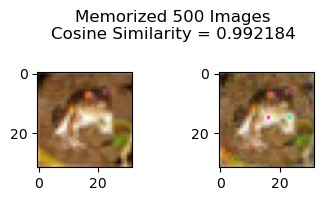

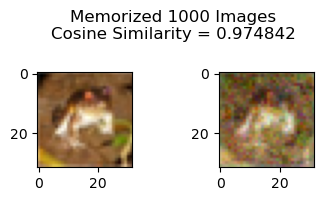

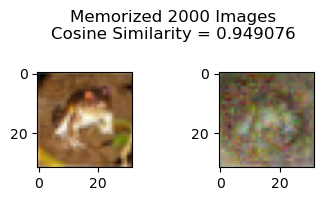

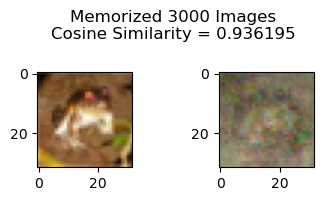

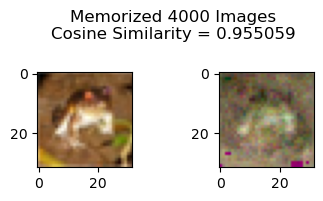

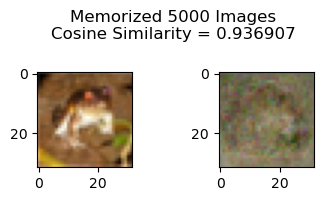

In [29]:
show_images_by_amount(temp_data=temp_data, temp_targets=temp_targets, index=0, device=device)

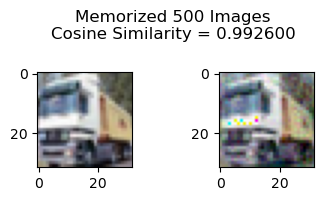

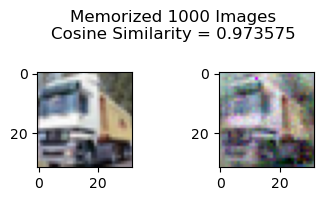

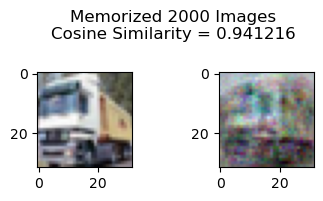

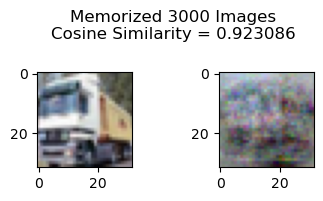

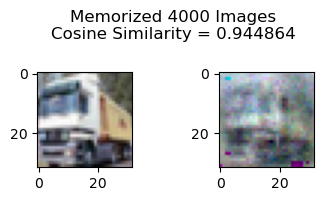

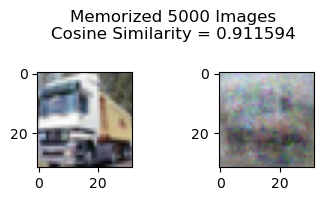

In [30]:
show_images_by_amount(temp_data=temp_data, temp_targets=temp_targets, index=1, device=device)

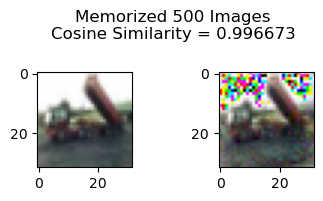

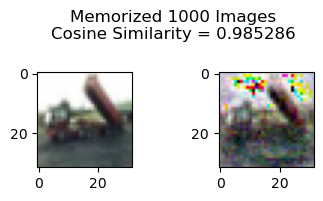

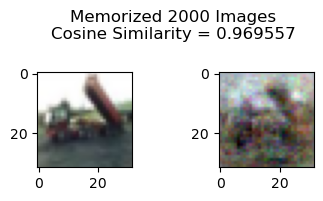

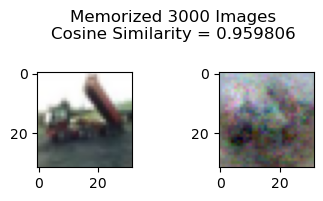

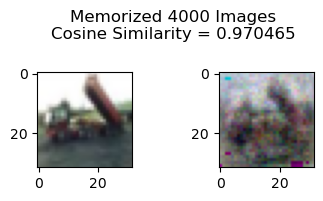

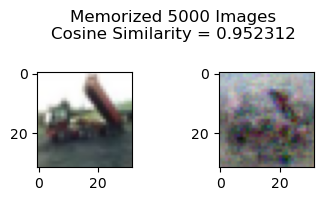

In [31]:
show_images_by_amount(temp_data=temp_data, temp_targets=temp_targets, index=2, device=device)

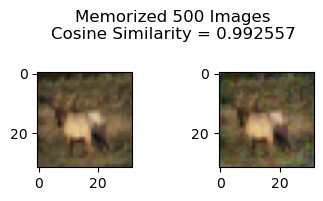

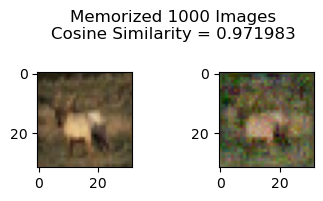

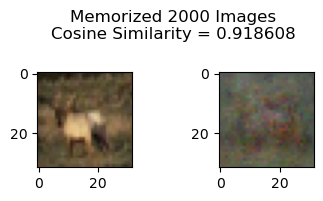

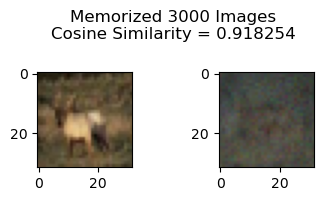

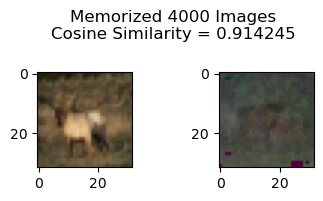

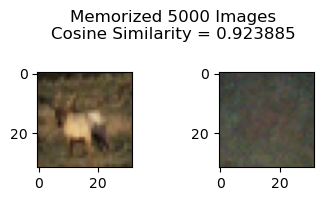

In [32]:
show_images_by_amount(temp_data=temp_data, temp_targets=temp_targets, index=3, device=device)